# Long Term EMA Crossover System

Philosophy:
The system intends to catch the longer term (i.e. several months or more) upswings in a stock as it gets revalued by the market.
It attempts to catch the longer term trends using a simple EMA crossover, and using a selection of fundamental filters to improve performance.
    

In [1]:
# Set up global imports including related packages
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import sys
import os
sys.path.append(os.path.join("C:\\Users", os.getlogin(), "Source\\Repos\\FinancialDataHandling\\financial_data_handling"))
os.chdir(os.path.join("C:\\Users", os.getlogin(), "Source\\Repos\\EnsembleSystemDevelopment\\ensemble_trading_system"))

from store.file_system import Storage
# System imports
from data_types.market import Market
from system.core import Strategy, Portfolio
from system.core import VolatilityMultiplier, SizingStrategy
from measures.moving_averages import EMA
from measures.volatility import StdDevEMA
from measures.valuations import ValueRatio
from signals.level_signals import Crossover
from rules.signal_rules import PositionFromDiscreteSignal
from trade_modifiers.exit_conditions import StopLoss, TrailingStop, ReturnTriggeredTrailingStop
from trade_modifiers.filters import HighPassFilter
# Import analysis tools
from system.analysis import summary_report, cross_validate_portfolio
# Set up default plot parameters
%matplotlib inline
plt.rcParams["figure.figsize"] = (14, 5)

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


## Base Strategy vs Filtered Trades

In [2]:
store = Storage("NYSE")
# Base System configuration
strategy = Strategy(trade_timing = "O", ind_timing = "C")
strategy.market = Market(store)
strategy.signal_generator = Crossover(slow = EMA(120), fast = EMA(50))
strategy.position_rules = PositionFromDiscreteSignal(Up = 1)

# Run the strategy
strategy.run()
print("Generated {} trades.".format(strategy.trades.count))

Generated 5148 trades.


In [3]:
# Store the baseline results
buy_and_hold_trades = strategy.buy_and_hold_trades()
buy_and_hold_returns = strategy.market_returns
base_trades = strategy.trades
base_returns = strategy.returns
# Configure and apply filters
adjusted = ValueRatio('EPV', 'Adjusted')(strategy)
cyclic = ValueRatio('EPV', 'Cyclic')(strategy)
strategy.apply_filter(HighPassFilter(adjusted, 0.3))
strategy.apply_filter(HighPassFilter(cyclic, 0.0))
filtered_trades = strategy.trades
filtered_returns = strategy.returns
print('Filtered down to {} trades'.format(filtered_trades.count))

Filtered down to 32 trades


In [4]:
# Print trade statistics
summary = summary_report(
    Buy_and_hold = buy_and_hold_trades, 
    Base_strategy = base_trades,
    Filters_added = filtered_trades
)
print(summary)

                                Buy_and_hold  Base_strategy  Filters_added
Number of trades                      659.00        5148.00          32.00
Percent winners                        73.30          37.50          46.90
Number winners                        483.00        1931.00          15.00
Number losers                         172.00        3216.00          17.00
Number even                             4.00           1.00           0.00
Average return                         91.35           9.47          15.34
Average return inc slippage            90.25           8.37          14.24
Median return                          58.24          -3.37          -0.28
Average winning return                140.64          40.59          40.67
Average losing return                 -44.96          -9.21          -7.02
Ratio average win to loss               3.13           4.41           5.80
Largest winner                       1260.34         931.84          97.68
Largest loser            

## Stop loss analysis

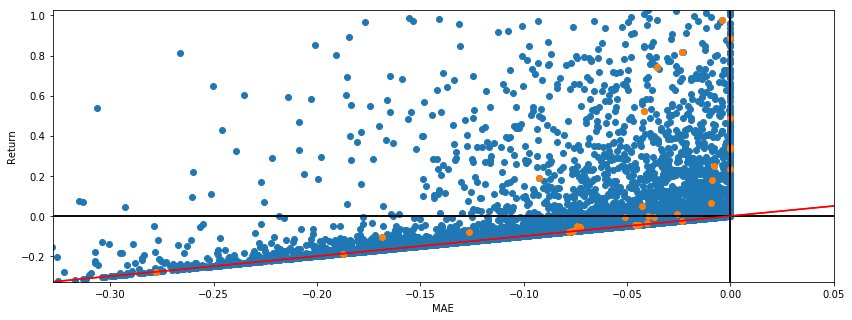

In [5]:
# Plot the maximum adverse excursion and maximum favourable excursion for the filtered trades.
base_trades.plot_MAE() # blue
filtered_trades.plot_MAE() # orange

Definitely some scope for stop losses, potentially at around 15%

In [6]:
# Analysis of various stop loss settings
from system.analysis import test_stop_loss, test_trailing_stop
stop_loss_summary = test_stop_loss(strategy, [0.3, 0.2, 0.15, 0.1, 0.05, 0.02])
print(stop_loss_summary)

                                  0.00    0.30    0.20    0.15    0.10  \
Number of trades                 32.00   32.00   32.00   32.00   32.00   
Percent winners                  46.90   46.90   46.90   46.90   46.90   
Number winners                   15.00   15.00   15.00   15.00   15.00   
Number losers                    17.00   17.00   17.00   17.00   17.00   
Number even                       0.00    0.00    0.00    0.00    0.00   
Average return                   15.34   15.34   15.34   15.41   16.02   
Average return inc slippage      14.24   14.24   14.24   14.31   14.92   
Median return                    -0.28   -0.28   -0.28   -0.28   -0.28   
Average winning return           40.67   40.67   40.67   40.67   40.67   
Average losing return            -7.02   -7.02   -7.02   -6.88   -5.73   
Ratio average win to loss         5.80    5.80    5.80    5.91    7.10   
Largest winner                   97.68   97.68   97.68   97.68   97.68   
Largest loser                   -27.80

Suprisingly still good results even with a tight 2% stop, however best seems to be around 10%

## Trailing stop analysis

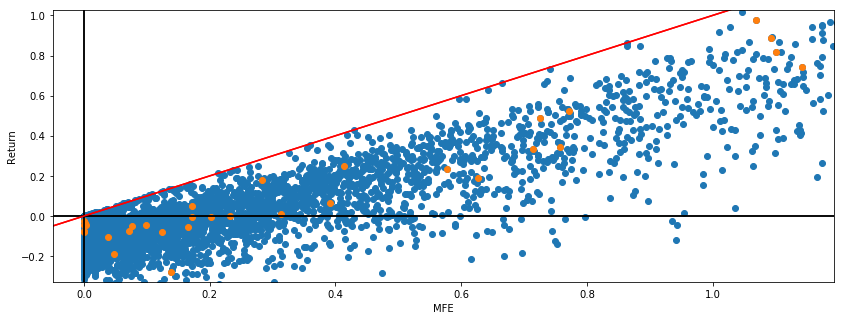

In [7]:
# Plot maximum favourable excursion to check typical end trade drawdowns.
base_trades.plot_MFE() # blue
filtered_trades.plot_MFE() # orange

### TODO
Should look at maximum intra-trade drawdown, vs end of trade drawdown to determine suitable trailing stops.

Larger trades will typically give up more than 10% (base system), and 20-30% (filtered system).

In [8]:
# Trailing stop analysis
trailing_stop_summary = test_trailing_stop(strategy, [0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02])
print(trailing_stop_summary)

                                  0.00    0.30    0.25    0.20    0.15  \
Number of trades                 32.00   32.00   32.00   32.00   32.00   
Percent winners                  46.90   46.90   43.80   46.90   46.90   
Number winners                   15.00   15.00   14.00   15.00   15.00   
Number losers                    17.00   17.00   18.00   17.00   17.00   
Number even                       0.00    0.00    0.00    0.00    0.00   
Average return                   15.34   15.34   15.56   16.43   14.12   
Average return inc slippage      14.24   14.24   14.46   15.33   13.02   
Median return                    -0.28   -0.28   -0.52   -0.52   -0.80   
Average winning return           40.67   40.67   43.67   42.10   35.81   
Average losing return            -7.02   -7.02   -6.30   -6.22   -5.03   
Ratio average win to loss         5.80    5.80    6.93    6.77    7.12   
Largest winner                   97.68   97.68   97.68   97.68   97.68   
Largest loser                   -27.80

Interestingly the Sharpe ratio (exluding slippage) and optimal F ratio continue to increase with tighter trailing stops.
However the typical trade duration and average return drops too far.
A trailing stop of 10-15% seems to be appropriate.

In [9]:
# Add stops and compare results
strategy.apply_exit_condition(StopLoss(0.1))
strategy.apply_exit_condition(TrailingStop(0.1))
stopped_trades = strategy.trades
stopped_returns = strategy.returns
summary['StopLoss_added'] = summary_report(stopped_trades)
print(summary)

                                Buy_and_hold  Base_strategy  Filters_added  \
Number of trades                      659.00        5148.00          32.00   
Percent winners                        73.30          37.50          46.90   
Number winners                        483.00        1931.00          15.00   
Number losers                         172.00        3216.00          17.00   
Number even                             4.00           1.00           0.00   
Average return                         91.35           9.47          15.34   
Average return inc slippage            90.25           8.37          14.24   
Median return                          58.24          -3.37          -0.28   
Average winning return                140.64          40.59          40.67   
Average losing return                 -44.96          -9.21          -7.02   
Ratio average win to loss               3.13           4.41           5.80   
Largest winner                       1260.34         931.84     

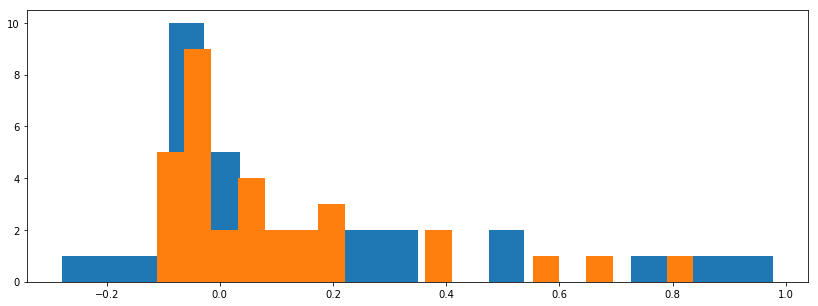

In [10]:
filtered_trades.hist(bins = 20)
stopped_trades.hist(bins = 20)

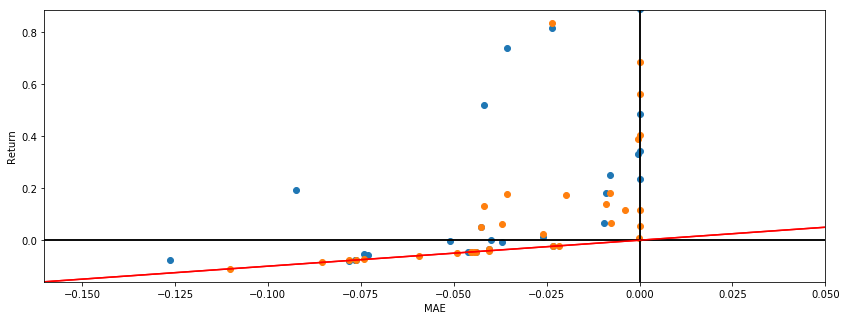

In [11]:
filtered_trades.plot_MAE()
stopped_trades.plot_MAE()

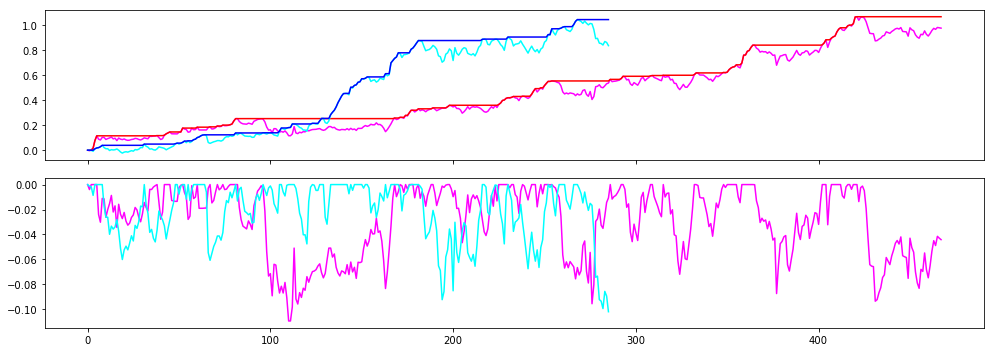

In [12]:
# Comparing biggest winners
max_filtered = filtered_trades.returns.max()
max_stopped = stopped_trades.returns.max()
max_filtered = filtered_trades.find(lambda t: t.base_return == max_filtered)[0]
max_stopped = stopped_trades.find(lambda t: t.base_return == max_stopped)[0]
fig, axarr = plt.subplots(nrows = 2, ncols = 1, sharex = True)
max_filtered.cumulative.plot(ax = axarr[0], color = 'magenta')
max_filtered.plot_highwater(ax = axarr[0], color = 'red')
max_filtered.plot_drawdowns(ax = axarr[1], color = 'magenta')
max_stopped.cumulative.plot(ax = axarr[0], color = 'cyan')
max_stopped.plot_highwater(ax = axarr[0], color = 'blue')
max_stopped.plot_drawdowns(ax = axarr[1], color = 'cyan')
fig.tight_layout()

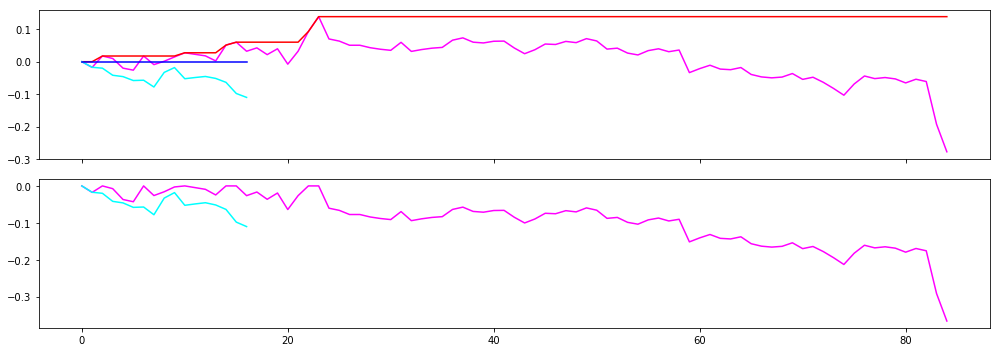

In [13]:
# Comparing biggest losers
min_filtered = filtered_trades.returns.min()
min_stopped = stopped_trades.returns.min()
min_filtered = filtered_trades.find(lambda t: t.base_return == min_filtered)[0]
min_stopped = stopped_trades.find(lambda t: t.base_return == min_stopped)[0]
fig, axarr = plt.subplots(nrows = 2, ncols = 1, sharex = True)
min_filtered.cumulative.plot(ax = axarr[0], color = 'magenta')
min_filtered.plot_highwater(ax = axarr[0], color = 'red')
min_filtered.plot_drawdowns(ax = axarr[1], color = 'magenta')
min_stopped.cumulative.plot(ax = axarr[0], color = 'cyan')
min_stopped.plot_highwater(ax = axarr[0], color = 'blue')
min_stopped.plot_drawdowns(ax = axarr[1], color = 'cyan')
fig.tight_layout()

## Portfolio Analysis

In [14]:
portfolio = Portfolio(strategy, 15000)
portfolio.sizing_strategy = SizingStrategy(diversifier = 0, min_size = 2500, max_size = 0.25)
portfolio.run()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000024FEE3E4F98>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000024FEE5F8550>], dtype=object)

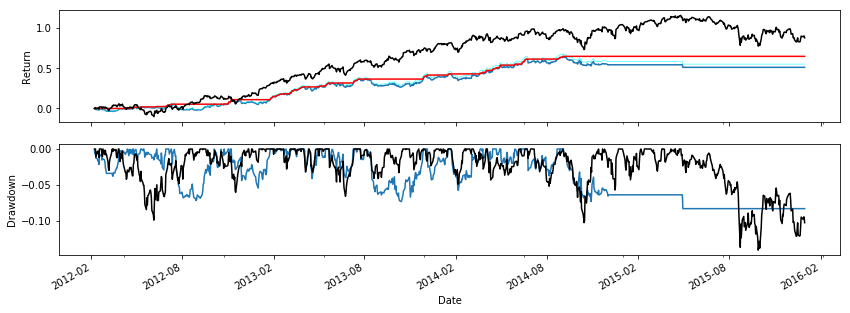

In [15]:
portfolio.plot_result()

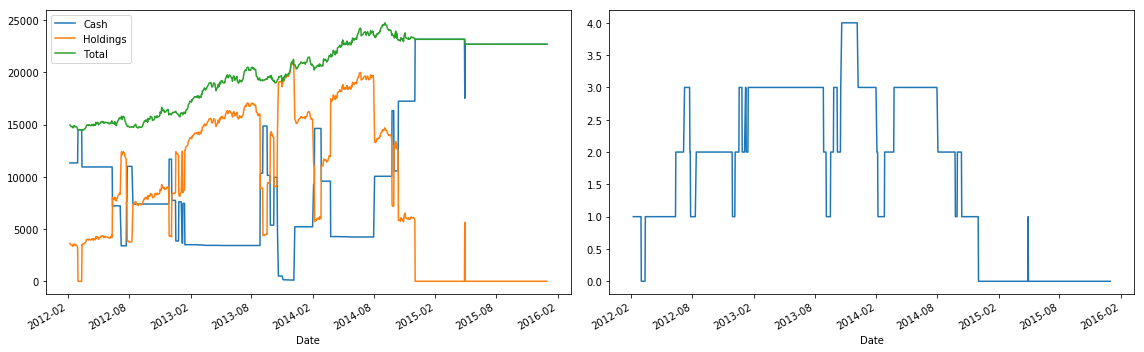

In [16]:
f, axarr = plt.subplots(1, 2, figsize = (16, 5))
portfolio.summary[portfolio.trade_start_date:].plot(ax = axarr[0])
portfolio.positions.num_concurrent()[portfolio.trade_start_date:].plot(ax = axarr[1])
plt.tight_layout()

In [17]:
portfolio_base_trades = portfolio.trades

In [18]:
# Add volatility sizing to the portfolio
volatilities = StdDevEMA(40)(strategy.indicator_prices.at(strategy.trade_entry))
portfolio.sizing_strategy.multipliers.append(VolatilityMultiplier(0.2, volatilities))
portfolio.reset()
portfolio.run()
portfolio_vol_tgt_20 = portfolio.trades
portfolio.sizing_strategy.multipliers.append(VolatilityMultiplier(0.3, volatilities))
portfolio.reset()
portfolio.run()
portfolio_vol_tgt_30 = portfolio.trades

In [19]:
portfolio_summary = summary_report(
    Base = portfolio_base_trades, 
    Vol20 = portfolio_vol_tgt_20, 
    Vol30 = portfolio_vol_tgt_30
)
print(portfolio_summary)

                                  Base   Vol20   Vol30
Number of trades                 18.00   22.00   21.00
Percent winners                  61.10   54.50   52.40
Number winners                   11.00   12.00   11.00
Number losers                     7.00   10.00   10.00
Number even                       0.00    0.00    0.00
Average return                   10.54    9.91   10.00
Average return inc slippage       9.44    8.81    8.90
Median return                     6.85    4.38    2.12
Average winning return           21.65   23.48   25.01
Average losing return            -6.91   -6.38   -6.50
Ratio average win to loss         3.13    3.68    3.85
Largest winner                   81.61   81.61   81.61
Largest loser                   -12.65  -12.65  -12.65
Sharpe by trade                   0.48    0.45    0.44
Sharpe by trade inc slippage      0.43    0.40    0.39
Sharpe annualised                 1.10    1.05    1.15
Sharpe annualised inc slippage    0.97    0.92    1.00
Opt F     

In [20]:
portfolio.sizing_strategy = SizingStrategy(diversifier = 0.2, min_size = 2500, max_size = 0.3)
portfolio.sizing_strategy.multipliers.append(VolatilityMultiplier(0.3, volatilities))
portfolio.reset()
portfolio.run()
portfolio_trades_2 = portfolio.trades
portfolio.sizing_strategy = SizingStrategy(diversifier = 0.5, min_size = 2500, max_size = 0.3)
portfolio.sizing_strategy.multipliers.append(VolatilityMultiplier(0.3, volatilities))
portfolio.reset()
portfolio.run()
portfolio_trades_5 = portfolio.trades
portfolio.sizing_strategy = SizingStrategy(diversifier = 0.8, min_size = 2500, max_size = 0.3)
portfolio.sizing_strategy.multipliers.append(VolatilityMultiplier(0.3, volatilities))
portfolio.reset()
portfolio.run()
portfolio_trades_8 = portfolio.trades
portfolio_summary2 = summary_report(
    Div2 = portfolio_trades_2, 
    Div5 = portfolio_trades_5, 
    Div8 = portfolio_trades_8
)
print(portfolio_summary2)

                                  Div2    Div5    Div8
Number of trades                 18.00   22.00   20.00
Percent winners                  55.60   54.50   55.00
Number winners                   10.00   12.00   11.00
Number losers                     8.00   10.00    9.00
Number even                       0.00    0.00    0.00
Average return                    7.87    7.98    9.07
Average return inc slippage       6.77    6.88    7.97
Median return                     6.17    2.91    4.38
Average winning return           19.51   20.05   21.65
Average losing return            -6.68   -6.50   -6.31
Ratio average win to loss         2.92    3.09    3.43
Largest winner                   43.61   81.61   81.61
Largest loser                   -12.65  -12.65  -12.65
Sharpe by trade                   0.48    0.38    0.42
Sharpe by trade inc slippage      0.42    0.33    0.37
Sharpe annualised                 1.04    0.98    0.97
Sharpe annualised inc slippage    0.89    0.83    0.84
Opt F     

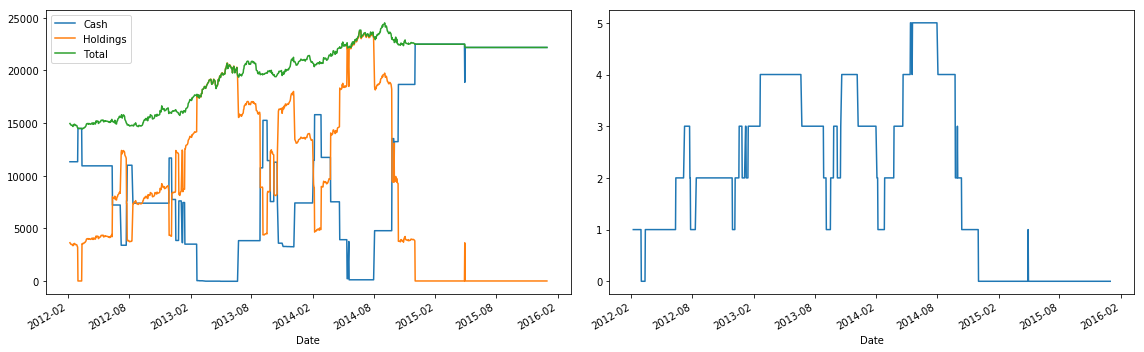

In [21]:
portfolio.sizing_strategy = SizingStrategy(diversifier = 0.5, min_size = 2500, max_size = 0.3)
portfolio.reset()
portfolio.run()
_, axarr = plt.subplots(1, 2, figsize = (16, 5))
portfolio.summary[portfolio.trade_start_date:].plot(ax = axarr[0])
portfolio.positions.num_concurrent()[portfolio.trade_start_date:].plot(ax = axarr[1])
plt.tight_layout()

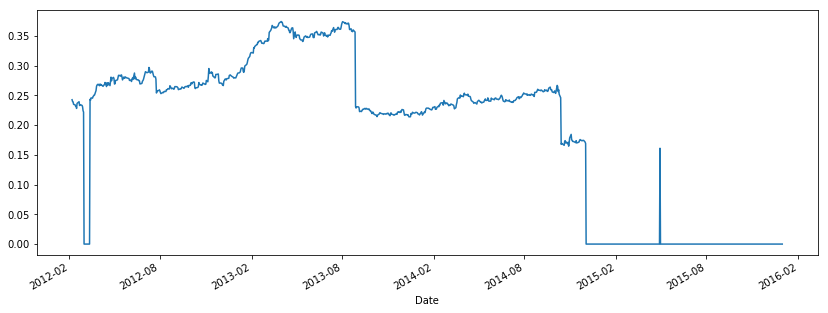

In [22]:
portfolio.max_position_percent()[portfolio.trade_start_date:].plot()

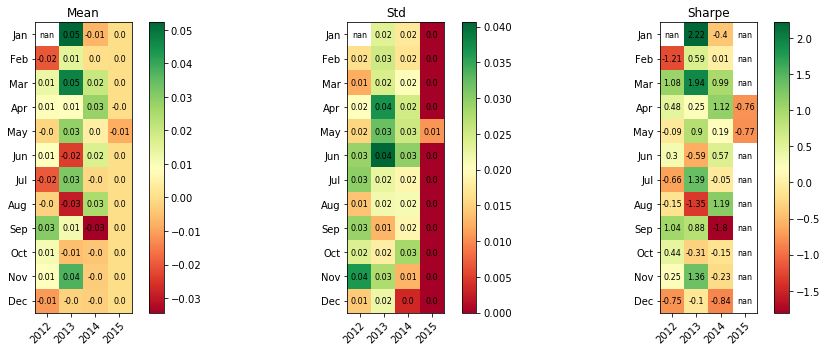

In [23]:
portfolio.returns.plot_monthly(start = portfolio.trade_start_date, values = ['mean', 'std', 'sharpe'])

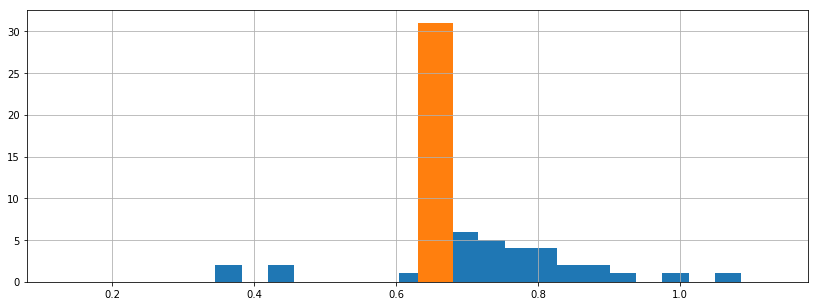

In [24]:
x_summary = cross_validate_portfolio(portfolio, N = 30)
x_summary['portfolio'].sharpe().hist(bins = 20)
x_summary['market'].sharpe().hist(bins = 20)

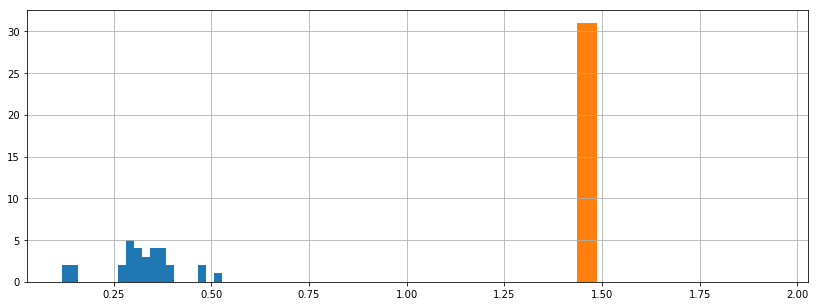

In [26]:
x_summary['portfolio'].final().hist(bins = 20)
x_summary['market'].final().hist(bins = 20)

In [29]:
x_summary['portfolio'].drawdowns()


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().